<a href="https://colab.research.google.com/github/ashlinleee/ashlinleee/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import cv2 as cv
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
# from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import cv2
from sklearn.metrics import confusion_matrix
import os

In [3]:
train_path = '/content/drive/MyDrive/mri images/Training/'
test_path = '/content/drive/MyDrive/mri images/Testing/'

print("type of Images in Train dataset"+str(os.listdir(train_path)))
print("type of Images in Test dataset"+str(os.listdir(test_path)))

type of Images in Train dataset['meningioma', 'glioma', 'notumor', 'pituitary']
type of Images in Test dataset['meningioma', 'notumor', 'pituitary', 'glioma']


meningioma images:


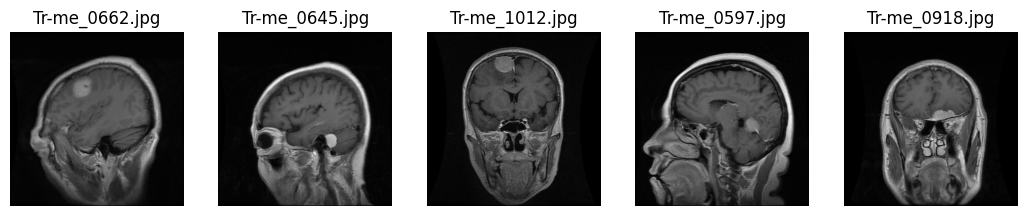

glioma images:


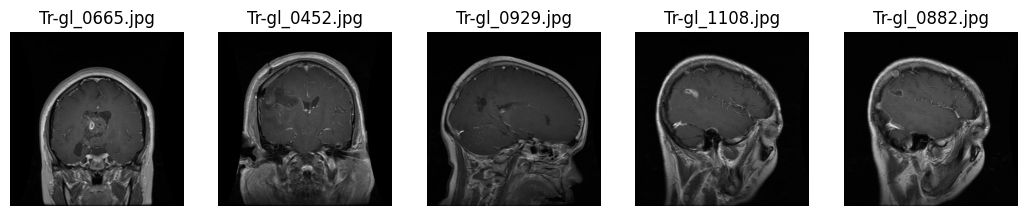

notumor images:


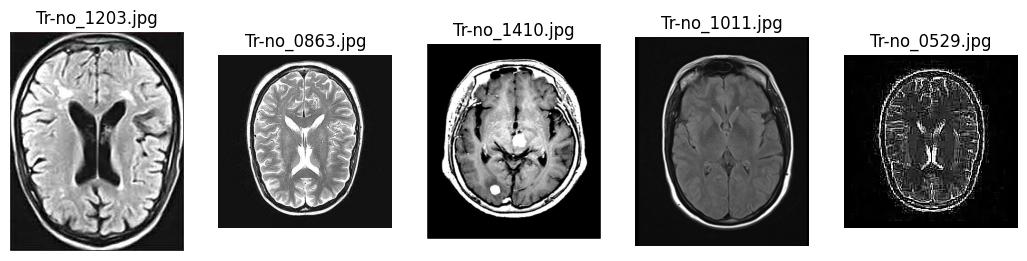

pituitary images:


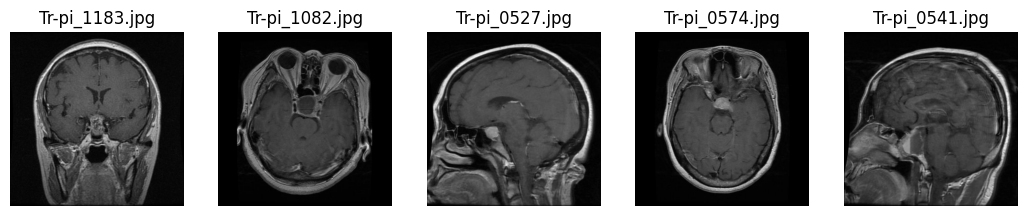

In [4]:
import matplotlib.pyplot as plt

rows, cols = (1, 5)

for category in os.listdir(train_path):
    print(f'{category} images:')
    category_path = os.path.join(train_path, category)

    fig = plt.figure(figsize=(13, 8))
    for i in range(rows * cols):
        fig.add_subplot(rows, cols, i + 1)

        # List image files in the specific category's directory
        image_files = os.listdir(category_path)
        if not image_files:
            continue

        # Select a random image file from the list
        random_image_id = np.random.choice(image_files)
        image = cv.imread(os.path.join(category_path, random_image_id))

        plt.imshow(image[:, :, ::-1])  # Convert BGR to RGB
        plt.title(random_image_id)
        plt.axis('off')

    plt.show()


In [5]:
from tqdm import tqdm
class_names =(os.listdir(train_path))
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (198, 198)

In [7]:
(os.listdir(train_path))

['meningioma', 'glioma', 'notumor', 'pituitary']

In [6]:
def load_data():

    datasets = ['/content/drive/MyDrive/mri images/Training/', '/content/drive/MyDrive/mri images/Testing/']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                #image = cv2.cvtColor(image, cv2.COLOR_RGB2RGB)
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [7]:
(x_train, y_train), (x_test, y_test) = load_data()

Loading /content/drive/MyDrive/mri images/Training/


100%|██████████| 1457/1457 [00:22<00:00, 63.93it/s] 


Loading /content/drive/MyDrive/mri images/Testing/


100%|██████████| 300/300 [00:02<00:00, 118.60it/s]


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

batch_size = 16
epochs = 50
data_augmentation = True
num_classes = len(class_names)

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

In [9]:
input_shape = x_train.shape[1:]
print(input_shape)

(198, 198, 3)


In [10]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [11]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (5712, 198, 198, 3)
5712 train samples
1311 test samples
y_train shape: (5712,)


In [12]:
y_train = keras.utils.to_categorical(y_train, num_classes=len(class_names))
y_test = keras.utils.to_categorical(y_test, num_classes=len(class_names))

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import time
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
import time
import numpy as np
import os
import psutil
# Define input shape and number of classes (Arecanut disease classes)
input_shape = (198, 198, 3)  # Typical input size for DenseNet121
num_classes = len(class_names)  # Change this to the number of classes in your dataset

# Create a DenseNet121 model with transfer learning
def create_densenet121_model(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())  # Reduce the feature map to a vector
    model.add(layers.Dense(1024, activation='relu'))  # Fully connected layer
    model.add(layers.Dropout(0.2))  # Dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for classification

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = create_densenet121_model(input_shape, num_classes)

# Summarize the model
model.summary()

# Measure Training Time
start_time = time.time()

history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=50,
    validation_data=(x_test, y_test),
    shuffle=True
)

end_time = time.time()

# Print training time
training_time = end_time - start_time
print(f"\nTotal Training Time: {training_time:.2f} seconds")

# Measure Memory Usage
process = psutil.Process(os.getpid())
memory_info = process.memory_info()
memory_used_mb = memory_info.rss / (1024 * 1024)  # Convert bytes to MB
print(f"Memory Usage: {memory_used_mb:.2f} MB")

# Measure Inference Time
sample_input = x_test[:1]  # Take one sample for inference
inference_start = time.time()
_ = model.predict(sample_input)
inference_end = time.time()
inference_time = inference_end - inference_start
print(f"Inference Time for one sample: {inference_time:.4f} seconds")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 6, 6, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,091,204 (30.87 MB)

 Trainable params: 1,053,700 (4.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 73s 119ms/step - accuracy: 0.7651 - loss: 0.7091 - val_accuracy: 0.8703 - val_loss: 0.3571
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.8868 - loss: 0.3165 - val_accuracy: 0.8696 - val_loss: 0.3499
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9058 - loss: 0.2664 - val_accuracy: 0.8871 - val_loss: 0.2926
Epoch 4/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9257 - loss: 0.2135 - val_accuracy: 0.9161 - val_loss: 0.2090
Epoch 5/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9358 - loss: 0.1769 - val_accuracy: 0.9207 - val_loss: 0.2063
Epoch 6/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9441 - loss: 0.1545 - val_accuracy: 0.8970 - val_loss: 0.2636
Epoch 7/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9455 - loss: 0.1418 - val_accuracy: 0.9359 - val_loss: 0.1860
Epoch 8/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.9399 - loss: 0.1550 -

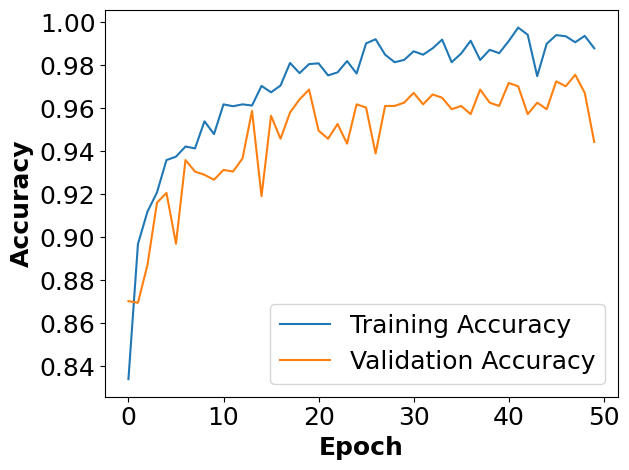

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
plt.ylabel('Accuracy',fontsize=18,weight='bold')
plt.xlabel('Epoch',fontsize=18,weight='bold')
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

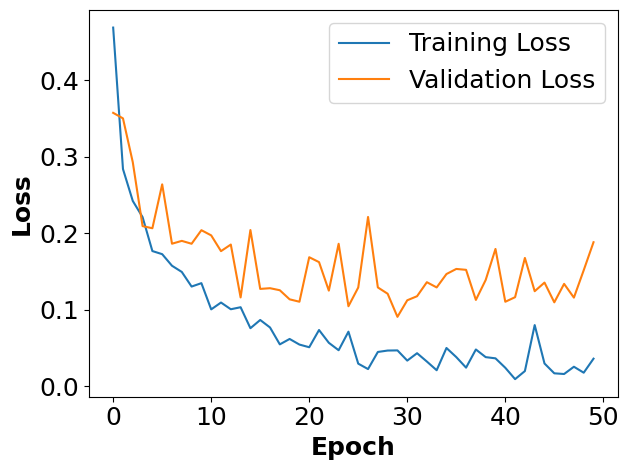

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
plt.ylabel('Loss',fontsize=18,weight='bold')
plt.xlabel('Epoch',fontsize=18,weight='bold')
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

In [16]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 416ms/step - accuracy: 0.9741 - loss: 0.0714
Test loss: 0.18799735605716705
Test accuracy: 0.9443173408508301


In [17]:
from sklearn.metrics import confusion_matrix

def calculate_metrics(model, X_train, y_train, X_test, y_test):
    # Predictions on training and test datasets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Convert predicted probabilities to binary predictions (0 or 1)
    y_train_pred_binary = np.argmax(y_train_pred, axis=1)
    y_test_pred_binary = np.argmax(y_test_pred, axis=1)
    y_train_binary = np.argmax(y_train, axis=1)
    y_test_binary = np.argmax(y_test, axis=1)
    train_confusion_matrix = confusion_matrix(y_train_binary, y_train_pred_binary)
    test_confusion_matrix = confusion_matrix(y_test_binary, y_test_pred_binary)

    # Extract TP, TN, FP, FN values from confusion matrices
    train_tp = train_confusion_matrix[1, 1]
    train_tn = train_confusion_matrix[0, 0]
    train_fp = train_confusion_matrix[0, 1]
    train_fn = train_confusion_matrix[1, 0]

    test_tp = test_confusion_matrix[1, 1]
    test_tn = test_confusion_matrix[0, 0]
    test_fp = test_confusion_matrix[0, 1]
    test_fn = test_confusion_matrix[1, 0]

    # Calculate ratios
    train_false_positive_rate = train_fp / (train_fp + train_tn)
    train_false_negative_rate = train_fn / (train_fn + train_tp)
    train_true_positive_rate = train_tp / (train_tp + train_fn)
    train_true_negative_rate = train_tn / (train_tn + train_fp)

    test_false_positive_rate = test_fp / (test_fp + test_tn)
    test_false_negative_rate = test_fn / (test_fn + test_tp)
    test_true_positive_rate = test_tp / (test_tp + test_fn)
    test_true_negative_rate = test_tn / (test_tn + test_fp)

    return {
        "Train False Positive Rate": train_false_positive_rate,
        "Train False Negative Rate": train_false_negative_rate,
        "Train True Positive Rate": train_true_positive_rate,
        "Train True Negative Rate": train_true_negative_rate,
        "Test False Positive Rate": test_false_positive_rate,
        "Test False Negative Rate": test_false_negative_rate,
        "Test True Positive Rate": test_true_positive_rate,
        "Test True Negative Rate": test_true_negative_rate,
    }

# Example usage:
metrics = calculate_metrics(model, x_train, y_train, x_test, y_test)
print(metrics)

179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step
{'Train False Positive Rate': np.float64(0.0), 'Train False Negative Rate': np.float64(0.016654049962149888), 'Train True Positive Rate': np.float64(0.9833459500378501), 'Train True Negative Rate': np.float64(1.0), 'Test False Positive Rate': np.float64(0.016556291390728478), 'Test False Negative Rate': np.float64(0.15100671140939598), 'Test True Positive Rate': np.float64(0.8489932885906041), 'Test True Negative Rate': np.float64(0.9834437086092715)}


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoded to label
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded to label

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes,digits=4))

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
Classification Report:
               precision    recall  f1-score   support

           0     0.8296    0.9706    0.8946       306
           1     0.9768    0.8433    0.9052       300
           2     0.9951    1.0000    0.9975       405
           3     0.9861    0.9433    0.9642       300

    accuracy                         0.9443      1311
   macro avg     0.9469    0.9393    0.9404      1311
weighted avg     0.9502    0.9443    0.9447      1311



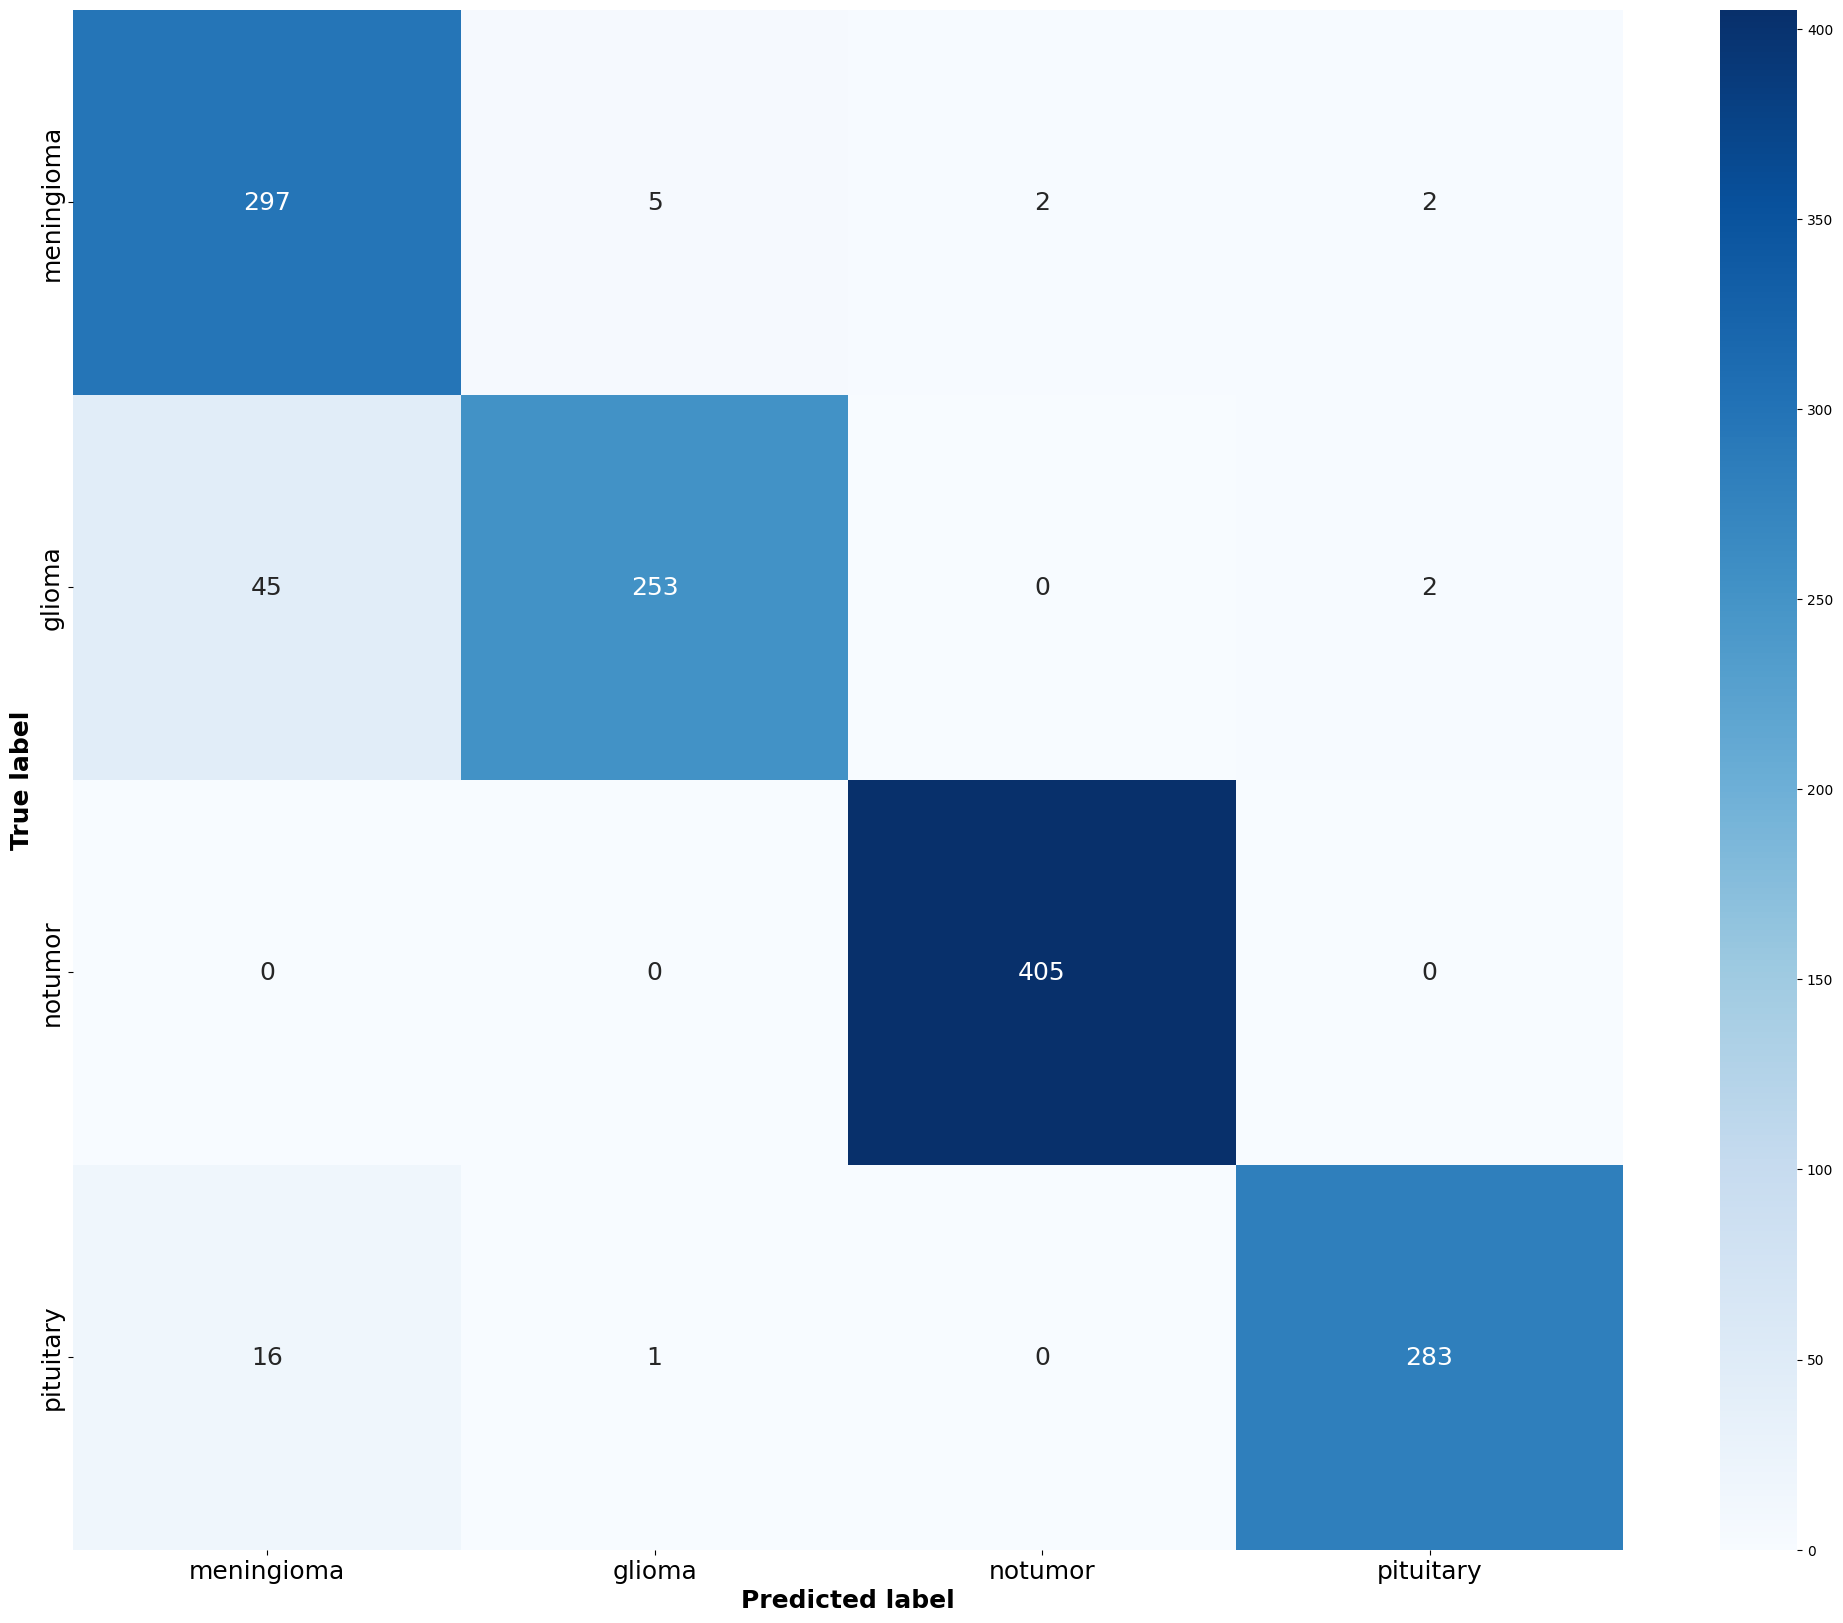

In [19]:
# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(25, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d',cmap='Blues', annot_kws={"size": 18}, xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix')
plt.ylabel('True label',fontsize=18,weight='bold')
plt.xlabel('Predicted label',fontsize=18,weight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


Class names: ['meningioma', 'glioma', 'notumor', 'pituitary']
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


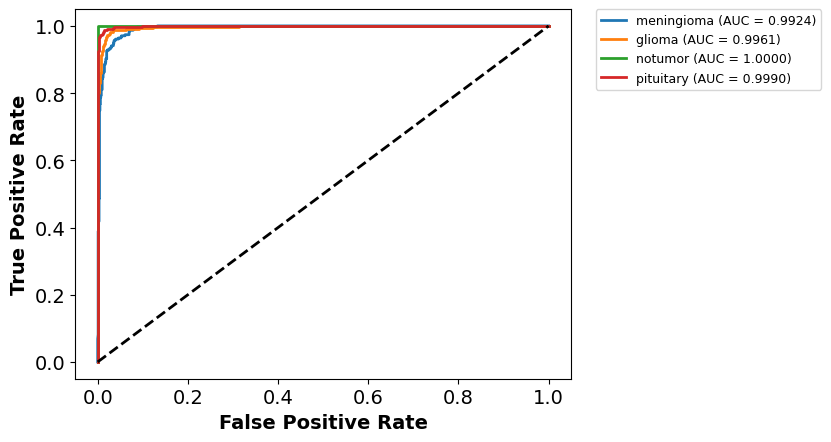

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# If y_test is one-hot encoded, convert it back to labels
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Get unique class names from y_true
y_true = np.array(y_true)  # Convert to NumPy array for consistent handling

# Print the class names
print(f"Class names: {class_names}")

# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_true, classes=np.arange(len(class_names)))

# Ensure y_score has the correct shape
y_score = model.predict(x_test)

# Check if y_score has more classes than class_names
if y_score.shape[1] > len(class_names):
    y_score = y_score[:, :len(class_names)]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=14,weight='bold')
plt.ylabel('True Positive Rate',fontsize=14,weight='bold')
# Place legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, borderaxespad=0.)
# plt.legend(fontsize=9)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Class names: ['meningioma', 'glioma', 'notumor', 'pituitary']
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step


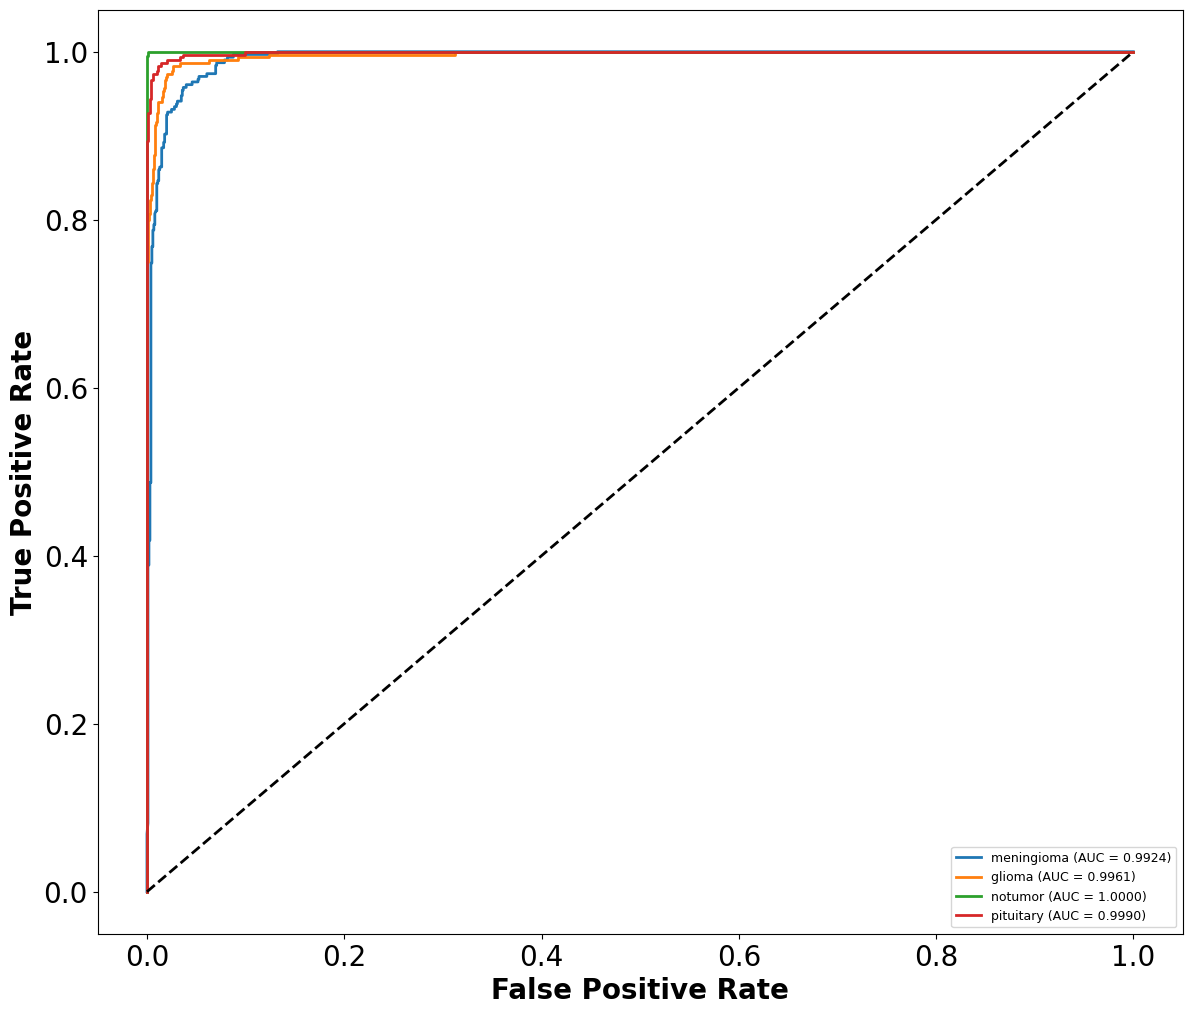

In [21]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# If y_test is one-hot encoded, convert it back to labels
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Get unique class names from y_true
y_true = np.array(y_true)  # Convert to NumPy array for consistent handling

# Print the class names
print(f"Class names: {class_names}")

# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_true, classes=np.arange(len(class_names)))

# Ensure y_score has the correct shape
y_score = model.predict(x_test)

# Check if y_score has more classes than class_names
if y_score.shape[1] > len(class_names):
    y_score = y_score[:, :len(class_names)]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(14, 12))
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=20,weight='bold')
plt.ylabel('True Positive Rate',fontsize=20,weight='bold')
# Place legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, borderaxespad=0.)
plt.legend(fontsize=9)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [22]:
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Predict on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class index


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


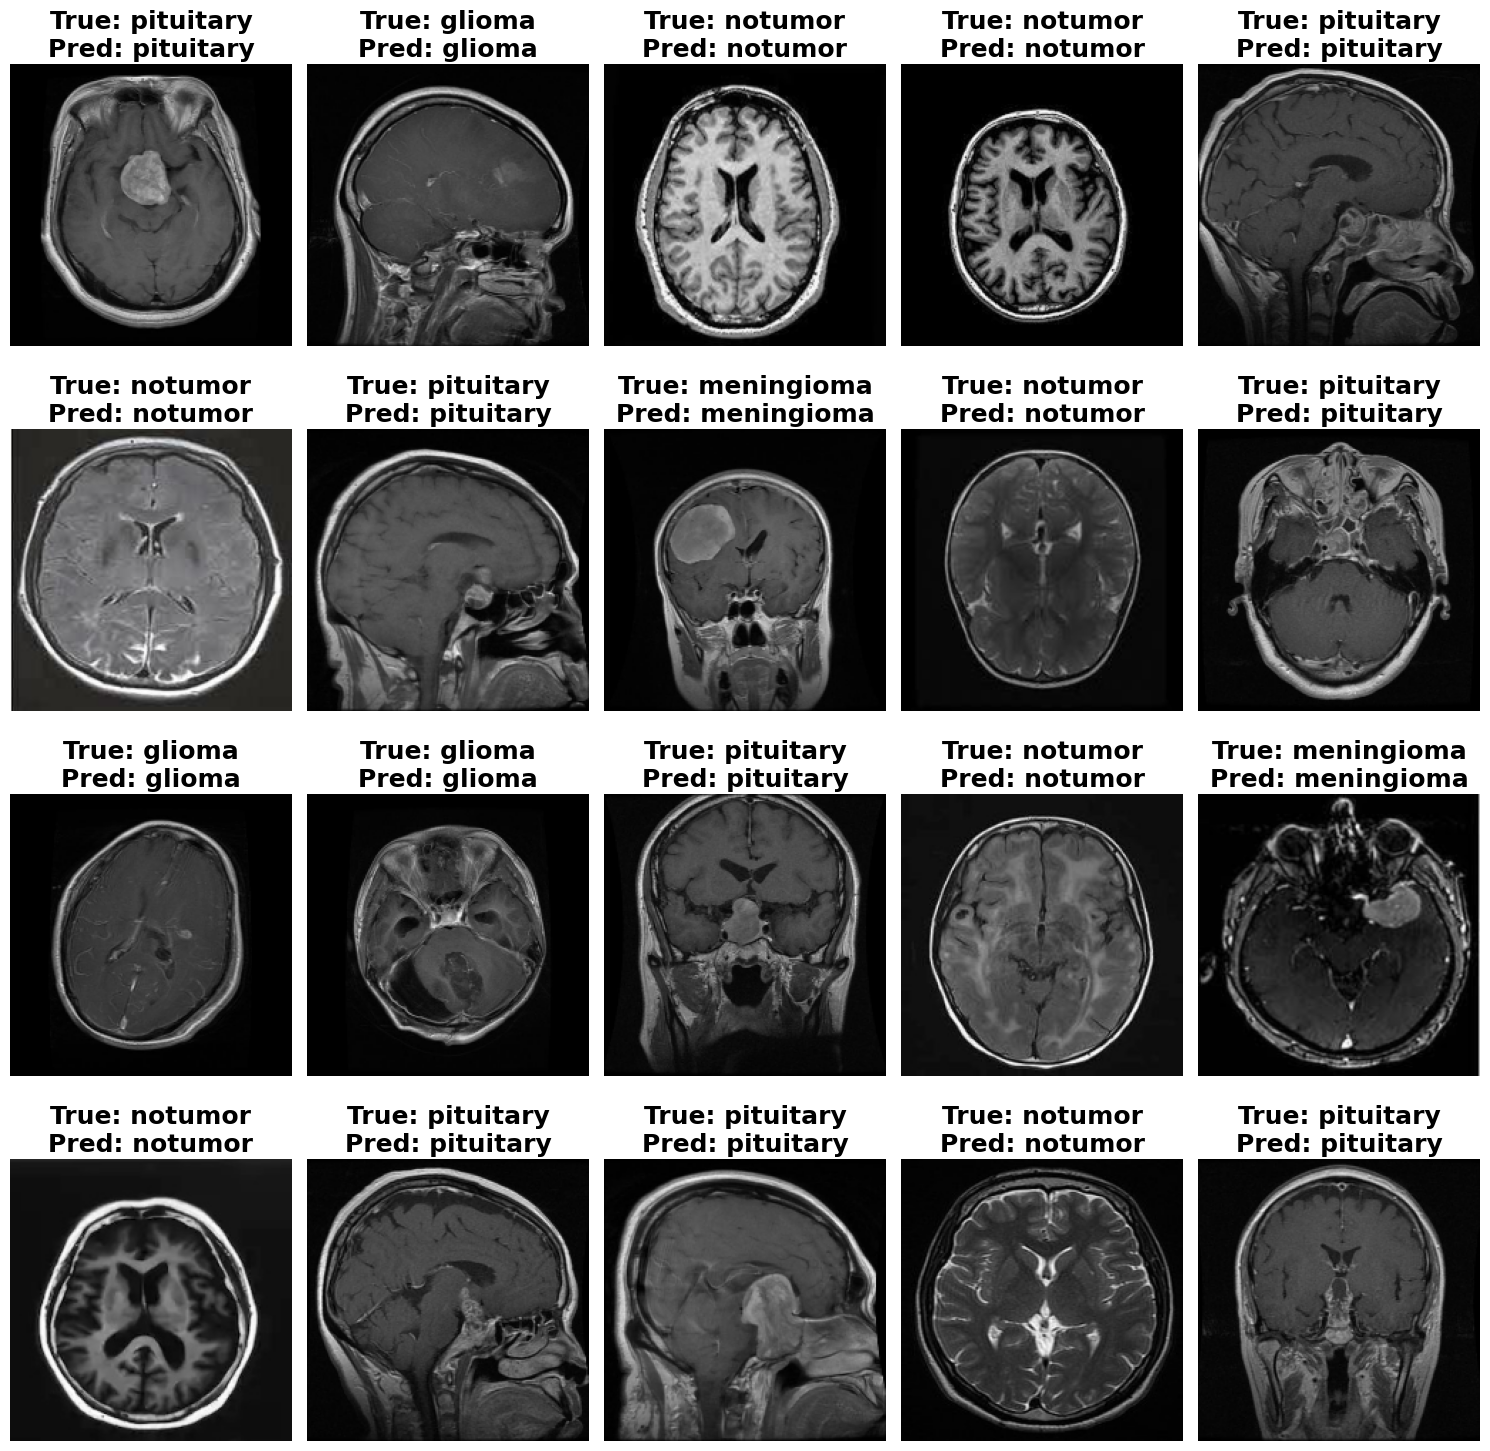

In [24]:
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Predict on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Choose random indices
num_images = 20
random_indices = random.sample(range(len(x_test)), num_images)

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)

    # Rescale if needed
    image = x_test[idx]
    if image.max() <= 1.0:
        image = (image * 255).astype('uint8')
    else:
        image = image.astype('uint8')

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    true_label_index = np.argmax(y_test[idx])
    pred_label_index = y_pred_classes[idx]

    true_label = list(class_names_label.keys())[list(class_names_label.values()).index(true_label_index)]
    pred_label = list(class_names_label.keys())[list(class_names_label.values()).index(pred_label_index)]

    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=18, weight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [25]:
model.save("brain_tumor_classification.keras")
